# Reconstructies op een hemelkaart
In dit notebook worden de richtingen van
deeltjeslawines bepaald en geplot op een projectie van de (sterren)hemel.

In [1]:
# dit notebook werkt onder Python 2 en 3
from __future__ import division, print_function

In [2]:
# importeer modules en functies
from datetime import datetime

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

import tables
from sapphire import download_coincidences, ReconstructESDCoincidences, ScienceParkCluster
from sapphire.utils import pbar
from sapphire.transformations.celestial import zenithazimuth_to_equatorial

## Download data

Download coincidenties tussen stations van het Science Park.
We nemen coincidenties tussen negen stations in een periode van een maand. Door
deze voorwaarde kiezen we showers met een hoge energie, waarvoor het interessant
is om de aankomstrichting uit de ruimte te onderzoeken.


Open een HDF5 bestand,
waarin we onze data opslaan:

In [3]:
DATAFILE = 'coinc.h5'

In [4]:
data = tables.open_file(DATAFILE, 'w')

Definieer de dataset:

* STATIONS = lijst van stations
* START = eerste tijdstip
in `datetime`
* END = laatste tijdstip als `datetime`
* N = minimum aantal
stations per coincidentie

Tip: Gebruik `datetime?` om informatie te krijgen
over het datetime object.

Suggestie: Gebruik coincidenties tussen
(bijvoorbeeld) minimaal zes stations.

In [5]:
STATIONS = [102, 104, 105]
START = datetime(2016, 1, 1)
END = datetime(2016, 7, 1)
N = 3

Download coincidenties uit de ESD ([data.hisparc.nl](data.hisparc.nl)) en sla ze
op in het HDF5 bestand:

In [6]:
download_coincidences(data, stations=STATIONS, start=START, end=END, n=N)

100%|############################################################|Time: 0:03:13


In [7]:
print("Aantal showers (coincidenties n=%d stations): %d " % (N, len(data.root.coincidences.coincidences)))

Aantal showers (coincidenties n=3 stations): 43562 


## Reconstrueer richting van de showers
Reconstrueer en verwijder showers
waarvan de richting niet gereconstrueerd konden worden (Zowel de zenit-hoek als
azimut van die showers is NaN).

In [8]:
rec = ReconstructESDCoincidences(data, overwrite=True)
rec.reconstruct_and_store()

N/A%|                                                           |ETA:  --:--:--/Users/niekschultheiss/anaconda3/lib/python3.6/site-packages/sapphire/analysis/event_utils.py:101: RuntimeWarning: All-NaN axis encountered
  station))
100%|############################################################|Time: 0:01:06
N/A%|                                                           |ETA:  --:--:--/Users/niekschultheiss/anaconda3/lib/python3.6/site-packages/sapphire/analysis/event_utils.py:33: RuntimeWarning: Mean of empty slice
  station=station))
100%|############################################################|Time: 0:01:03


In [9]:
recs = data.root.coincidences.reconstructions.read()
theta = recs['zenith']
recs = recs.compress(~np.isnan(theta))

Maak een histrogram van de zenit-hoeken om de kwaliteit van de data te
controleren:

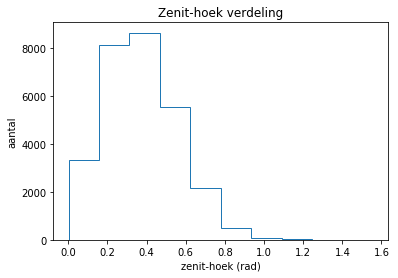

In [10]:
plt.hist(recs['zenith'], histtype='step')
plt.title('Zenit-hoek verdeling')
plt.xlabel('zenit-hoek (rad)')
plt.ylabel('aantal')
plt.show()

## Coordinatentransformatie naar rechte-klimming en declinatie

De richting van
de events (`zenit-hoek` en `azimut` ten opzicht van een ENU-assenstelsel in het
cluster) wordt getransformeerd naar rechte klimming en declinatie.

Voor de
coordinatentransformatie naar rechte-klimming en declinatie is de
positie van
ENU-assenstelsel van het cluster nodig:

In [11]:
lla = ScienceParkCluster().get_lla_coordinates()
lat, lon, alt = lla
print(lat, lon)

52.35560171835574 4.950527376134917


Reken elk event om naar rechte klimming (RA) en declinatie (DEC). En schaal deze
naar (-pi, pi) voor het plotten. Sla de RA,DEC paren op in de lijst `events`

In [12]:
events = []
for rec in pbar(recs):
    timestamp = rec['ext_timestamp'] / 1.e9
    theta = rec['zenith']
    phi = rec['azimuth']
    r, d = zenithazimuth_to_equatorial(lat, lon, timestamp, theta, phi)
    events.append((r-np.pi, d))
events = np.array(events)

100%|############################################################|Time: 0:00:04


Histrogram ter controle:

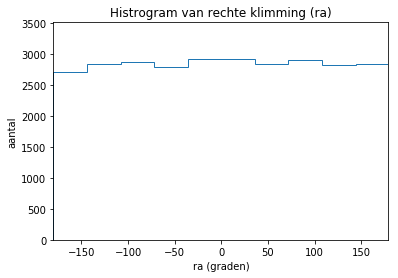

In [13]:
ra = np.degrees(events[:,0])
plt.title('Histrogram van rechte klimming (ra)')
n, bins, _ = plt.hist(ra, histtype='step')  # n is het aantal events per bin
plt.xlabel('ra (graden)')
plt.ylabel('aantal')
plt.xlim([-180, 179])
plt.ylim([0, 1.2*max(n)])
plt.show()

In [14]:
acceptancy8 = [0.3363585796261457, 0.4036459673827963, 0.48137582301457327, 0.5706453351695145, 
              0.6725911920803603, 0.7883808849932021, 0.9192027339945607, 1.0662546827071926, 
              1.2307319320620893, 1.4138135072055378, 1.6166478751306614, 1.8403377533881602, 
              2.0859242717848034, 2.3543706688819164, 2.6465457229363905, 2.963207132284946, 
              3.304985072691922, 3.6723661685356954, 4.065678120619933, 4.485075235637992, 
              4.930525100726029, 5.401796641009878, 5.898449788547505, 6.419826977626167, 
              6.965046664095122, 7.532999045474167, 8.122344134217403, 8.7315123090367, 
              9.358707438968231, 10.001912642322658, 10.658898708267232, 11.327235173062988, 
              12.004304006471429, 12.687315827130025, 13.373328529365724, 14.059268168573242, 
              14.741951918530543, 15.418112882450677, 16.08442651075804, 16.73753835309676, 
              17.374092850502013, 17.99076285665452, 18.5842795654701, 19.151462516033295, 
              19.68924934420688, 20.194724952607643, 20.66514977688097, 21.097986836197244, 
              21.490927269445727, 21.841914075493893, 22.14916379584963, 22.411185900813493, 
              22.626799665419654, 22.795148348788814, 22.915710519595088, 22.988308400809434, 
              23.013113138343673, 22.990646930305033, 22.92178198590592, 22.807736315292523, 
              22.650066383306918, 22.450656691148332, 22.211706379738217, 21.93571297703066, 
              21.625453438288613, 21.28396265322948, 20.914509616735923, 20.52057148035267, 
              20.10580571991466, 19.674020670263452, 19.229144691034968, 18.775194237892197, 
              18.31624112131446, 17.85637924014733, 17.39969107959669, 16.950214263270414, 
              16.511908446308688, 16.08862283168753, 15.684064584541456, 15.301768409945655, 
              14.945067548160557, 14.617066428008183, 14.320615203966478, 14.058286385884344, 
              13.832353752090162, 13.644773717242067, 13.497169305707246, 13.390816859712128, 
              13.326635589131621, 13.305180046734966]

In [15]:
acceptancy9 = [0.20026072212018692, 0.24551422710742543, 0.29889294286566637, 0.36144215642241323, 
              0.4342730999823025, 0.5185570188244059, 0.6155175695713596, 0.726421511992794, 
              0.8525676878467341, 0.9952743130367506, 1.1558646439957987, 1.3356511150532016, 
              1.5359180798912972, 1.7579033262985964, 2.0027785684913217, 2.271629154505623, 
              2.565433256762837, 2.8850408411067656, 3.2311527326721756, 3.604300115193763, 
              4.004824813206524, 4.432860713515356, 4.888316682924044, 5.370861333229395, 
              5.879909971752099, 6.414614056173582, 6.973853446300522, 7.5562317128485335, 
              8.160074724827004, 8.78343269315702, 9.424085799426782, 10.079553485966603, 
              10.747107427589917, 11.423788147369415, 12.106425179734712, 12.791660625077805, 
              13.475975882049557, 14.155721287944177, 14.827148345105865, 15.48644416322238, 
              16.12976770471124, 16.753287384114746, 17.353219543407512, 17.92586730420042, 
              18.467659285558245, 18.975187672789264, 19.445245128140815, 19.87486004868276, 
              20.261329699436867, 20.602250780495748, 20.895547024798212, 21.139493467569743, 
              21.33273707826371, 21.47431350011705, 21.563659700056842, 21.600622391511433, 
              21.585462153518023, 21.518853230216084, 21.40187905424157, 21.236023594619645, 
              21.02315868350342, 20.76552752563521, 20.46572463894976, 20.126672513657795, 
              19.751595309961402, 19.34398994091714, 18.907594906705004, 18.4463572596486, 
              17.964398085892554, 17.465976889938744, 16.95545526266972, 16.43726020255385, 
              15.915847444039011, 15.395665127385666, 14.881118121106336, 14.37653328254441, 
              13.886125914731439, 13.41396764928681, 12.963955956520287, 12.539785455761994, 
              12.144921171911458, 11.782573858811565, 11.455677486767629, 11.16686897068888, 
              10.91847019716331, 10.712472393399407, 10.550522868383341, 10.43391414669366, 
              10.36357550797414, 10.34006693977795]

In [16]:
acceptancy10 = [0.11989156437675617, 0.1501602527608089, 0.18661736324434494, 0.23020729425411135, 
              0.28195849900014974, 0.3429811462554002, 0.4144629558410489, 0.49766306660034987, 
              0.5939038239761792, 0.7045604091993112, 0.8310482720901596, 0.9748083739506772, 
              1.1372902951859518, 1.3199333132071656, 1.5241456087562884, 1.7512818118750004, 
              2.002619151048421, 2.279332519266694, 2.5824688175212938, 2.9129209782584087, 
              3.2714021072685893, 3.6584202112044797, 4.074253998312036, 4.5189302511130505, 
              4.992203270949588, 5.493536884965159, 6.0220894859562515, 6.576702544530833, 
              7.155892991366036, 7.757849815536218, 8.380435163612365, 9.021190154494116, 
              9.677345547936236, 10.345837321894617, 11.023327126744345, 11.706227494864997, 
              12.390731593905711, 13.072847223160487, 13.748434666853234, 14.413247937679754, 
              15.06297887053918, 15.693303461762596, 16.29992979491438, 16.878646851829767, 
              17.4253734781656, 17.936206757309282, 18.407469045613674, 18.83575293586104, 
              19.217963444496863, 19.551356761045856, 19.83357495439887, 20.062676099174055, 
              20.237159364630855, 20.3559846968981, 20.418586820582558, 20.424883385991254, 
              20.375277190940626, 20.27065250909259, 20.11236565760391, 19.902230033316126, 
              19.64249593658939, 19.335825583217687, 18.985263775914962, 18.594204766167703, 
              18.16635588367613, 17.705698543356007, 17.21644725853135, 16.703007293466026, 
              16.169931579095156, 15.621877493416553, 15.063564073525843, 14.49973018106468, 
              13.935094088507672, 13.374314892062703, 12.821956089983946, 12.282451594882126, 
              11.760074377288047, 11.258907867380179, 10.782820174444, 10.335441121154805, 
              9.920142033841783, 9.540018181920125, 9.197873720807047, 8.896208963683629, 
              8.63720978890569, 8.422738981826338, 8.25432931204739, 8.13317815909596, 
              8.060143520341091, 8.03574126344317]

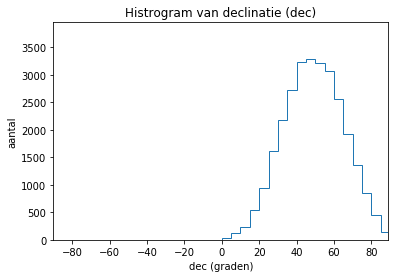

[ 0.00010081  0.00042084  0.00085105  0.00203279  0.00364404  0.00651643
  0.00926303  0.01232722  0.01577238  0.01754795  0.01896029  0.02053146
  0.0199103   0.01807433  0.01635118  0.01410891  0.01220755  0.01137947]
[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5]


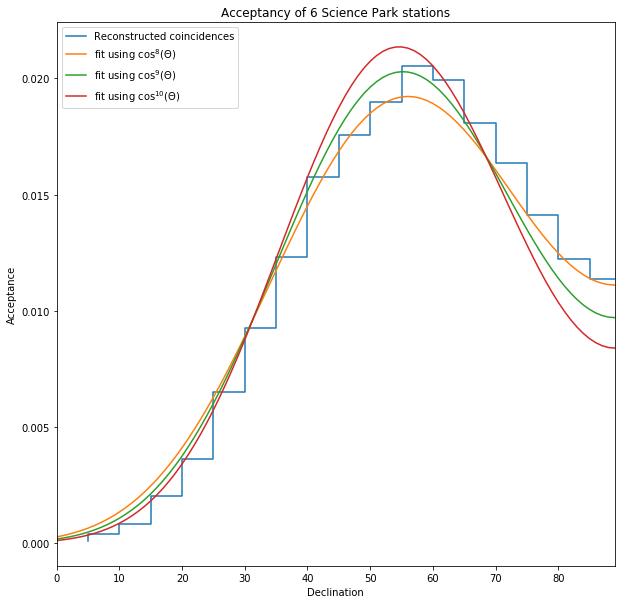

In [17]:
dec = np.degrees(events[:, 1])
plt.title('Histrogram van declinatie (dec)')
n, bins, _ = plt.hist(dec, np.arange(0, 19) * 5., histtype='step')  # n is het aantal events per bin
plt.xlabel('dec (graden)')
plt.ylabel('aantal')
plt.xlim([-90, 89])
plt.ylim([0, 1.2*max(n)])
plt.show()
#area = np.sin(np.radians(bins[1:])) - np.sin(np.radians(bins[:-1]))
area = 2. * np.pi * (np.cos(np.radians(bins[:-1])) - np.cos(np.radians(bins[1:])))
area = area[::-1]
bincentres = (bins[1:]+bins[:-1])/2
N = n/area
N = N / (5. * sum(N))

fig = plt.figure(figsize=(10,10))
plt.title("Acceptancy of 6 Science Park stations")
plt.step(bins[1:], N, label="Reconstructed coincidences")
plt.plot(np.arange(0,90), np.array(acceptancy8) / sum(acceptancy8), label="fit using $\cos^8(\Theta)$")
plt.plot(np.arange(0,90), np.array(acceptancy9) / sum(acceptancy9), label="fit using $\cos^9(\Theta)$")
plt.plot(np.arange(0,90), np.array(acceptancy10) / sum(acceptancy10), label="fit using $\cos^{10}(\Theta)$")
plt.xlabel("Declination")
plt.ylabel("Acceptance")
plt.xlim([0, 89])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

print(N)
print(bincentres)

# Definitie van plots

Hier worden de plot functies `plot_events_on_mollweide()`
en `plot_events_polar()` gedefinieerd.

In [18]:
# RA, DEC tuples van het steelpan asterisme in het sterrenbeeld Grote Beer
steelpan = np.array([[13.792222, 49.3167], [13.398889, 54.9333], [12.900556, 55.95],
                     [12.257222, 57.0333], [11.896944, 53.7000], [11.030833, 56.3833],
                     [11.062222, 61.7500], [12.257222, 57.0333]])
# Melkweg contouren als lijst van RA, DEC paren.
# `milky_way.npy` heeft *geen* verbinding tussen RA 23h59 en 0h00 en `milky_way_polar.npy` wel.
try:
    mw_contour = np.load('milky_way.npy') 
    mw_contour_polar = np.load('milky_way_polar.npy')
except:
    mw_contour = mw_contour_polar = []

In [19]:
def plot_events_on_mollweide(events, filename=None):
    """Plot events (een lijst van RA, DEC tuples) op een kaart in Mollweide projectie"""
    
    events = np.array(events)
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.set_xticklabels(['2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'], fontsize='large')
    ax.grid(True)
    
    # plot milky way contours
    for ra_mw, dec_mw in mw_contour:
        ax.plot(ra_mw, dec_mw, color='grey')
    
    # plot steelpan in UMa
    ra_uma = np.radians(steelpan[:, 0] / 24 * 360 - 180.)
    dec_uma = np.radians(steelpan[:, 1])
    ax.plot(ra_uma, dec_uma, color='red')
    ax.scatter(ra_uma, dec_uma, color='red')
    # plot Polaris
    ax.scatter(0., np.radians(90), color='red')
    
    # plot reconstructions
    ax.scatter(events[:,0], events[:,1], marker='.')
    if filename:
        plt.savefig(filename, dpi=200)

In [20]:
def plot_events_polar(events, filename=None):
    """Plot events (een lijst van RA, DEC paren) op een hemelkaart van de noordelijke hemel"""

    events = np.array(events)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection="polar")
    ax.set_xticklabels(['12h', '15h', '18h', '21h', '0h', '3h', '6h', '9h'], fontsize=30)
    ax.set_yticklabels(['80', '70', '60', '50', '40', '30', '20', '10', '0'], fontsize=30, color='grey')

    ax.grid(True)
    
    # plot milky way contours
    for ra_mw, dec_mw in mw_contour_polar:
        ax.plot(ra_mw, 90. - np.degrees(dec_mw), color='grey')

    # plot UMa
    ra_uma = np.radians(steelpan[:, 0] / 24 * 360 - 180.)
    dec_uma = np.radians(steelpan[:, 1])
    ax.plot(ra_uma, 90. - np.degrees(dec_uma), color='red')
    ax.scatter(ra_uma, 90. - np.degrees(dec_uma), color='red')
    # plot Polaris
    ax.scatter(0., 0., color='red')

    # plot reconstructions
    ax.scatter(events[:,0], 90. - np.degrees(events[:,1]), marker='.')
    ax.set_rmax(90.0)
    if filename:
        plt.savefig(filename, dpi=200)
    plt.show()

# Maak plots

/Users/niekschultheiss/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


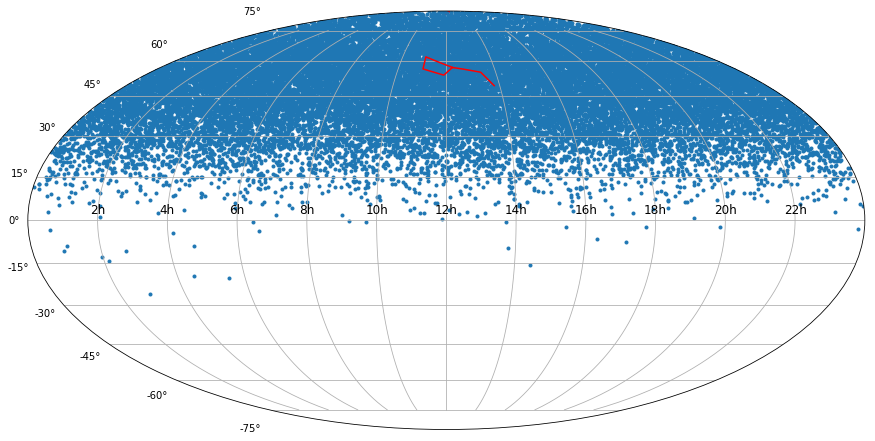

In [21]:
plot_events_on_mollweide(events, filename='noordelijke hemel.png')

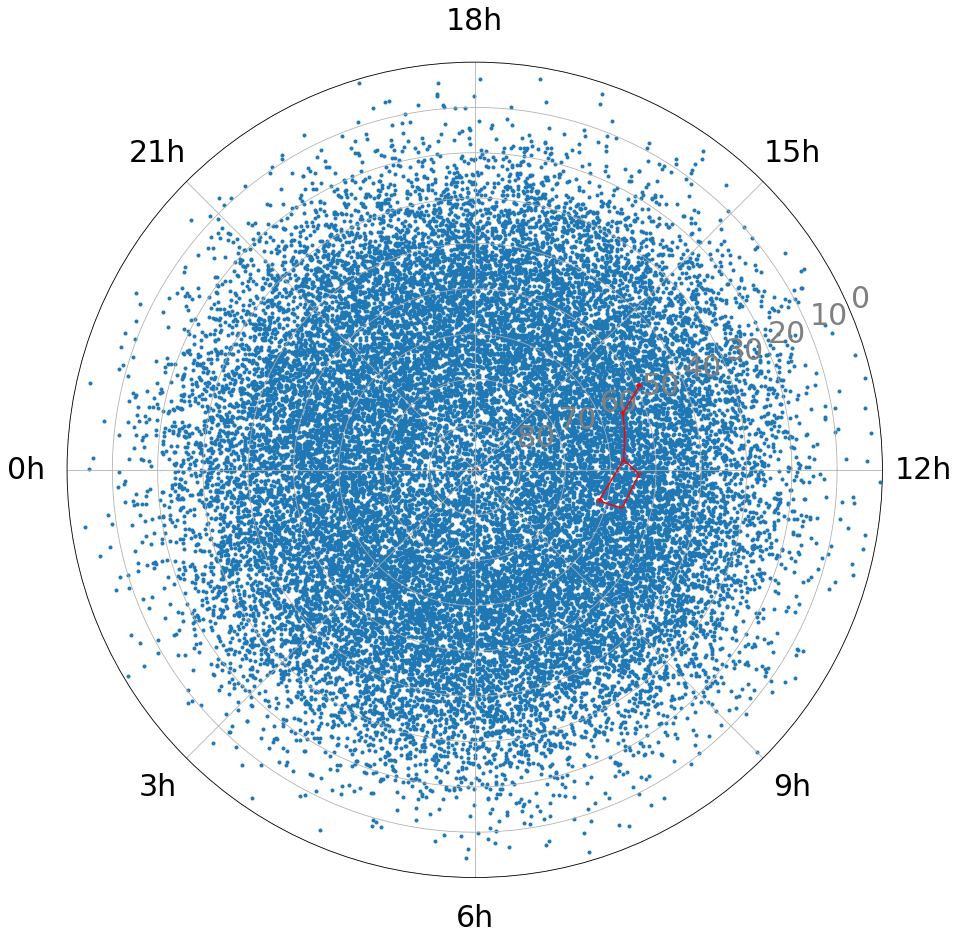

In [22]:
plot_events_polar(events, filename='noordelijke hemel.png')

In [23]:
data.close()

In [24]:
events

array([[ 0.31803087,  0.98341043],
       [-0.20150568,  0.24911909],
       [ 0.8212436 ,  0.9258994 ],
       ..., 
       [ 1.66851354,  0.48235521],
       [ 1.22190167,  1.09620316],
       [ 2.08477767,  0.73727924]])

In [25]:
ra = events[:,0] + np.pi
dec = np.pi / 2 - events[:,1] 
2. * np.pi - max(ra)

4.3402251929336444e-05

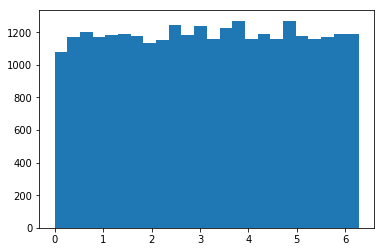

In [26]:
a = plt.hist(ra,24)

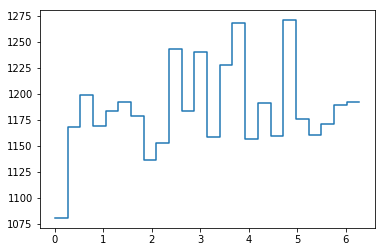

In [27]:
b = [a[0][0]]
for value in a[0]:
    b.append(value)
plt.step(a[1], b)

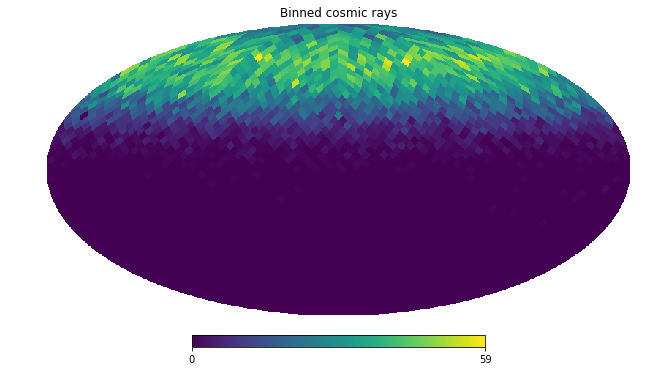

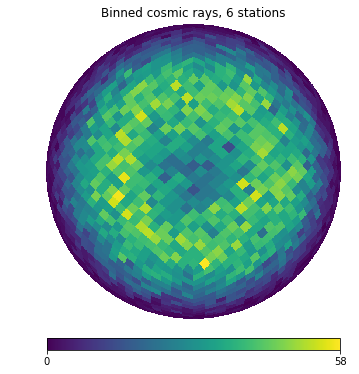

In [28]:
NSIDE = 16 #the map garannularity
m = np.zeros(12 * NSIDE ** 2)
for event in events:
    theta = np.pi / 2 - event[1]
    phi = event[0]
    if phi < 0:
        phi += 2 * np.pi
    m[hp.ang2pix(NSIDE, theta, phi)] += 1
hp.mollview(m, title="Binned cosmic rays")
m = np.zeros(12 * NSIDE ** 2)
for event in events:
    phi1 = event[1]
    theta1 = event[0]
    phi = np.arctan2(np.sin(phi1), np.cos(phi1) * np.sin(theta1))
    theta = np.arccos(np.cos(phi1) * np.cos(theta1))
    if phi < 0:
        phi += np.pi
    if 0 < theta < np.pi and 0 < phi < 2 * np.pi:
        m[hp.ang2pix(NSIDE, theta, phi - np.pi / 2)] += 1
hp.orthview(m, half_sky="true", title="Binned cosmic rays, 6 stations")

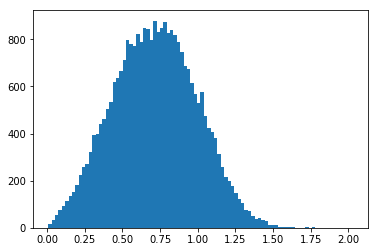

In [29]:
binned = plt.hist(dec,90)

In [30]:
flux = binned[0] / (np.radians((binned[1][1:] + binned[1][:-1]) /2))

In [31]:
flux

array([  4.61619269e+04,   4.32393733e+04,   4.95971265e+04,
         4.99689771e+04,   4.91302540e+04,   4.98922640e+04,
         5.04311033e+04,   4.95288975e+04,   5.22983609e+04,
         5.81379115e+04,   6.10143415e+04,   5.86598845e+04,
         6.40299614e+04,   7.24972966e+04,   6.82965181e+04,
         7.09118829e+04,   6.97299335e+04,   7.21146004e+04,
         7.24846598e+04,   7.93786787e+04,   7.77722676e+04,
         7.77154217e+04,   7.95632402e+04,   8.54311762e+04,
         8.01409793e+04,   7.62480852e+04,   7.80652708e+04,
         7.24183554e+04,   7.51272080e+04,   7.22665171e+04,
         6.58677325e+04,   7.04506395e+04,   6.47301157e+04,
         6.38724044e+04,   6.40161308e+04,   5.88117815e+04,
         5.80461004e+04,   5.50955008e+04,   5.18369834e+04,
         4.77172908e+04,   4.28621810e+04,   4.12276037e+04,
         3.66316134e+04,   3.31184160e+04,   3.01033939e+04,
         3.20070975e+04,   2.57670722e+04,   2.25614950e+04,
         2.11590415e+04,

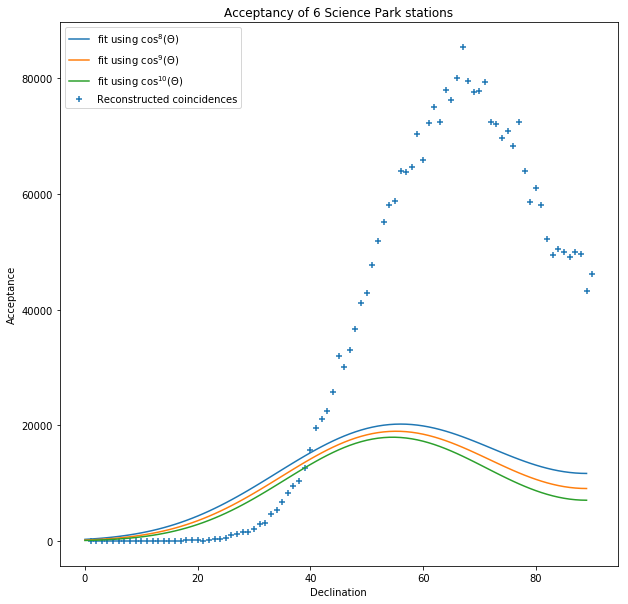

In [32]:
fig = plt.figure(figsize=(10,10))
plt.title("Acceptancy of 6 Science Park stations")
plt.scatter(90 - np.arange(0,len(flux)), flux, marker="+", label="Reconstructed coincidences")
plt.plot(np.arange(0,90), np.array(acceptancy8) * max(binned[0]), label="fit using $\cos^8(\Theta)$")
plt.plot(np.arange(0,90), np.array(acceptancy9) * max(binned[0]), label="fit using $\cos^9(\Theta)$")
plt.plot(np.arange(0,90), np.array(acceptancy10) * max(binned[0]), label="fit using $\cos^{10}(\Theta)$")
plt.xlabel("Declination")
plt.ylabel("Acceptance")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

In [33]:
max(binned[0])

879.0

In [34]:
bins

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.])

In [35]:
area = 2. * np.pi * (np.cos(np.radians(bins[:-1])) - np.cos(np.radians(bins[1:])))

In [36]:
area[::-1]

array([ 0.54761568,  0.543448  ,  0.53514434,  0.52276792,  0.50641291,
        0.4862038 ,  0.46229438,  0.43486663,  0.40412927,  0.37031625,
        0.3336849 ,  0.294514  ,  0.25310168,  0.2097631 ,  0.16482809,
        0.11863864,  0.07154629,  0.02390942])